Import dataset

In [1]:
import numpy as np
import torch
from data.dataset import OneDDatasetLoader, DatasetLoader
from typing import List
from preprocessing.batching import merge_graphs

def train_eval_split(dataset : DatasetLoader, train_id : List, eval_id : List):
    # Get batching id
    if dataset._sub_dir == '/batched/':
        batching_id = dataset.batching_id.numpy()
        train_id = list(np.where(np.isin(batching_id, train_id) == True)[0])
        eval_id = list(np.where(np.isin(batching_id, eval_id) == True)[0])
    # Train dataset
    train_dataset = [dataset[i] for i in train_id]
    # Test dataset
    eval_dataset = [dataset[i] for i in eval_id]
    return train_dataset, eval_dataset

In [2]:
dataset = OneDDatasetLoader(
    root_dir='/data1/tam/downloaded_datasets_nodeattr_all',
    sub_dir='/calculated/'
)
print('Dataset loaded.')

batched_dataset = dataset.batching(batch_size=None, batch_n_times=10, recursive=True,
                                    sub_dir='/batched/')
print('Dataset batching finished.')

batched_dataset = OneDDatasetLoader(
    root_dir='/data1/tam/downloaded_datasets_nodeattr_all',
    sub_dir='/batched/'
)

train_dataset, eval_dataset = train_eval_split(
    dataset=batched_dataset,
    train_id=list(range(0,10)),
    eval_id=list(range(20,30))
)
print('Train/eval spliting finished.')

Dataset loaded.
Dataset batching finished.
Train/eval spliting finished.


In [ ]:
train_dataset

Train

In [3]:
import os
import torch
from networks.network_parc import PARC
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from networks.network_recurrent import objectview
CUDA_LAUNCH_BLOCKING=1
torch.cuda.empty_cache()

# Model params
args = objectview({
    'n_fields' : 2,
    'n_timesteps' : 1,
    'n_hiddenfields' : 128,
    'n_meshfields' : dataset[0].node_attr.size(1),
    'timesteps' : 0.02,
    'device' : torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    'lr' : 5e-7,
    'weight_decay' : 5e-4,
    'epoch' : 100,
    'train_lambda' : 1.0
})

# Model initializing
model = PARC(
    n_fields=args.n_fields,
    n_timesteps=args.n_timesteps,
    n_hiddenfields=args.n_hiddenfields,
    n_meshfields=args.n_meshfields
)
model = model.to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
criterion = torch.nn.MSELoss()
# criterion = WeightedMSELoss()

In [4]:
# Train function v2
def train(model, data, args):
    n_time = data.pressure.size(1)
    edge_index = data.edge_index.to(args.device)
    mesh_features = data.node_attr.to(args.device)
    F_initial = torch.cat([data.pressure[:,0].unsqueeze(1), data.velocity[:,0].unsqueeze(1)], dim=-1)\
                .to(args.device) # concat pressure and velocity
    model.n_timesteps = n_time - 1

    Fs, F_dots = model(F_initial, mesh_features, edge_index)

    Fs_hat = torch.cat([data.pressure.unsqueeze(-1), data.velocity.unsqueeze(-1)], dim=-1)\
                .to(args.device) # concat pressure and velocity
    
    # F_dots_hat = cal_derivative(Fs_hat, dim=1, delta_t=args.timesteps)
    F_dots_hat = torch.cat([data.pressure_dot.unsqueeze(-1), data.velocity_dot.unsqueeze(-1)], dim=-1)\
                .to(args.device) # concat pressure and velocity

    Fs_hat = Fs_hat[:,1:,:]
    F_dots_hat = F_dots_hat[:,1:,:]

    # print(Fs_hat, Fs)
    loss = (1.-args.train_lambda)*criterion(Fs_hat, Fs) + \
            args.train_lambda*criterion(F_dots_hat, F_dots)

    # return loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Eval function
def eval(model, data, args):
    n_time = data.pressure.size(1)
    edge_index = data.edge_index.to(args.device)
    mesh_features = data.node_attr.to(args.device)
    F_initial = torch.cat([data.pressure[:,0].unsqueeze(1), data.velocity[:,0].unsqueeze(1)], dim=-1)\
                .to(args.device) # concat pressure and velocity
    model.n_timesteps = n_time - 1

    with torch.no_grad():
        Fs, F_dots = model(F_initial, mesh_features, edge_index)

        Fs_hat = torch.cat([data.pressure.unsqueeze(-1), data.velocity.unsqueeze(-1)], dim=-1)\
                    .to(args.device) # concat pressure and velocity
        
        # F_dots_hat = cal_derivative(Fs_hat, dim=1, delta_t=args.timesteps)
        F_dots_hat = torch.cat([data.pressure_dot.unsqueeze(-1), data.velocity_dot.unsqueeze(-1)], dim=-1)\
                .to(args.device)

        Fs_hat = Fs_hat[:,1:,:]
        F_dots_hat = F_dots_hat[:,1:,:]

        loss = (1.-args.train_lambda)*criterion(Fs_hat, Fs) + \
            args.train_lambda*criterion(F_dots_hat, F_dots)

    # return loss
    return loss.item()

# Training
total_train_loss = []
total_eval_loss = []
# batch = enumerate(list(range(0,10)))
for epoch in range(args.epoch):
    torch.cuda.empty_cache()
    train_loss = 0
    for data in train_dataset:
        train_loss += train(model=model, data=data, args=args)
    # train_loss.backward()
    # optimizer.step()
    # train_loss = train_loss.item()
    train_loss /= len(train_dataset)
    total_train_loss.append(train_loss)

    eval_loss = 0
    for data in eval_dataset:
        eval_loss += eval(model=model, data=data, args=args)
    # eval_loss = eval_loss.item()
    eval_loss /= len(eval_dataset)
    total_eval_loss.append(eval_loss)
    
    if (epoch > 1):
        args.train_lambda = 0.5
    print(f'Epoch {epoch}: train loss = {train_loss}; eval loss = {eval_loss}')
    if (epoch+1) % 25 == 0:
        torch.save(model.state_dict(), f'models/parc_v2_epoch{epoch+1}.pth')
    
    

Epoch 0: train loss = 0.057437800266779956; eval loss = 0.01923308410216123
Epoch 1: train loss = 0.009751251524139661; eval loss = 0.005069727630470879
Epoch 2: train loss = 0.009242494446807541; eval loss = 0.012597846295684577
Epoch 3: train loss = 0.010426449577789754; eval loss = 0.011231537526473403
Epoch 4: train loss = 0.011211320364382119; eval loss = 0.010530366785824299
Epoch 5: train loss = 0.009430922287283466; eval loss = 0.00801746551762335
Epoch 6: train loss = 0.00677230486064218; eval loss = 0.005151227887836285
Epoch 7: train loss = 0.004305082908831537; eval loss = 0.0029230510248453357
Epoch 8: train loss = 0.003011897495598532; eval loss = 0.002389879778638715
Epoch 9: train loss = 0.003333575808937894; eval loss = 0.002929287965234835
Epoch 10: train loss = 0.003579571829759516; eval loss = 0.002504099225043319
Epoch 11: train loss = 0.0031212857187347255; eval loss = 0.0021597822735202497
Epoch 12: train loss = 0.0029168151566409508; eval loss = 0.00235591785021

In [5]:
# Save model
torch.save(model.state_dict(), 'models/parc_v2_final.pth')

Reconstruct CFD output

In [ ]:
# reconstruct CFD
def print_prediction(model, data):
    pass

In [12]:
# Model initializing
model = PARC(
    n_fields=args.n_fields,
    n_timesteps=args.n_timesteps,
    n_hiddenfields=args.n_hiddenfields,
    n_meshfields=args.n_meshfields
)
model = model.to(args.device)
model.load_state_dict(torch.load('models/parc_v2_epoch25.pth'))

<All keys matched successfully>

tensor(14.1667)


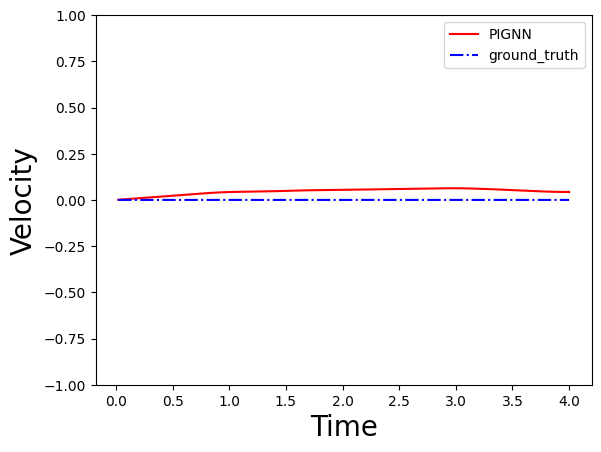

0.03884965553879738

In [60]:
# Plot prediction/ground truth
import matplotlib.pyplot as plt

def plot_comparison(model, data):
    n_time = data.pressure.size(1)
    edge_index = data.edge_index.to(args.device)
    mesh_features = data.node_attr.to(args.device)
    F_initial = torch.cat([data.pressure[:,0].unsqueeze(1), data.velocity[:,0].unsqueeze(1)], dim=-1)\
                .to(args.device) # concat pressure and velocity
    model.n_timesteps = n_time - 1

    with torch.no_grad():
        Fs, F_dots = model(F_initial, mesh_features, edge_index)

        Fs_hat = torch.cat([data.pressure.unsqueeze(-1), data.velocity.unsqueeze(-1)], dim=-1)\
                    .to(args.device) # concat pressure and velocity
        
        # F_dots_hat = cal_derivative(Fs_hat, dim=1, delta_t=args.timesteps)
        F_dots_hat = torch.cat([data.pressure_dot.unsqueeze(-1), data.velocity_dot.unsqueeze(-1)], dim=-1)\
                .to(args.device)

        Fs_hat = Fs_hat[:,1:,:]
        F_dots_hat = F_dots_hat[:,1:,:]

        loss = (1.-args.train_lambda)*criterion(Fs_hat, Fs) + \
            args.train_lambda*criterion(F_dots_hat, F_dots)
        
        total_loss = loss.item()
    # print(Fs.size(), Fs_hat.size())
    
    

    
    # plot
    i_node = 55000
    i_field = 1
    print((data.node_attr[i_node,5] + 1)*25/2)
    y_pred = Fs.cpu().numpy()[i_node,:,i_field]
    y_true = Fs_hat.cpu().numpy()[i_node,:,i_field]
    x = [i * 4.0 /200 for i in range(1,201)]
    plt.plot(x, y_pred, c='red', label='PIGNN')
    plt.plot(x, y_true, c='blue', linestyle='dashdot', label='ground_truth')
    plt.ylim([-1,1])
    plt.legend(loc='upper right')
    plt.ylabel('Velocity', fontsize=20)
    plt.xlabel('Time', fontsize=20)
    plt.show()
    
    return total_loss
    
plot_comparison(model, dataset[5])